# Projeto Redes Neurais 
Integrantes:Diogo Shiroto
            Hugo Leonardo
            Sheyla Lima
            Lucas Amorim

**Importações**

In [1]:
import numpy as np
from sklearn import metrics
import pandas as pd
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, average_precision_score, mean_squared_log_error
import scikitplot as skplt
import matplotlib
import matplotlib.pyplot as plt

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
data_set = pd.read_table('TRN')
#data_set.drop_duplicates(inplace=True)  # Remove exemplos repetidos

In [3]:
#Segura em DataFrame ainda param mais na frente fazer o Sampling
X = data_set.iloc[:,1:-2]
y = data_set.iloc[:,-2:-1]

In [4]:
## Treino: 50%, Validação: 25%, Teste: 25%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/4, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/3, random_state=42, stratify=y_train)

In [5]:
#Replicando a classe minoritária para os conjuntos de Treinamento e Validação
X_train = pd.concat((X_train,y_train),axis=1) #concatena a coluna a direita
X_train_c0 = X_train.loc[X_train.IND_BOM_1_1 == 0]
X_train_c1 = X_train.loc[X_train.IND_BOM_1_1 == 1]

#Sampling no Conjunto de Treinamento de C2
c0_train = X_train_c0.sample(n = X_train_c1.IND_BOM_1_1.count(),random_state = 1,replace = True)
#Previsores Classe 1 + Previsores Classe 2
X_train = X_train_c1.append(c0_train).reset_index(drop=True)
#Embaralhando os registros
X_train = X_train.sample(frac=1).reset_index(drop=True)

#Separando em Previsores e Classes
y_train = X_train.iloc[:,-1].values
X_train = X_train.iloc[:,0:-1].values



#VALIDAÇÃO
X_val = pd.concat((X_val,y_val),axis=1) #concatena a coluna a direita
X_val_c0 = X_val.loc[X_val.IND_BOM_1_1 == 0]
X_val_c1 = X_val.loc[X_val.IND_BOM_1_1 == 1]

#Sampling no Conjunto de Treinamento de C2
c0_val = X_val_c0.sample(n = X_val_c1.IND_BOM_1_1.count(),random_state = 1,replace = True)
#Previsores Classe 1 + Previsores Classe 2
X_val = X_val_c1.append(c0_val).reset_index(drop=True)
#Embaralhando os registros
X_val = X_val.sample(frac=1).reset_index(drop=True)

#Separando em Previsores e Classes
y_val = X_val.iloc[:,-1].values
X_val = X_val.iloc[:,0:-1].values


In [6]:
#Escalonamento das variáveis
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test.values)


# Montagem da rede MLP

# MLP 1
Quantidade de camadas intermediárias = 0
Quantidade de neurônios = 16 e 1 respectivamente
Funções de ativação = relu e sigmoid respectivamente
Taxa de aprendizagem = 1

In [9]:
# Número de features do nosso data set.
input_dim = X_train.shape[1]

# Aqui criamos o esboço da rede.
# activation = 'tanh', 'relu', 'sigmoid', 'softmax'
classifier = Sequential()

classifier.add(Dense(16, activation='relu'))
classifier.add(Dense(1, activation='sigmoid'))

# Por fim compilamos o modelo especificando um otimizador, a função de custo, e opcionalmente
# métricas para serem observadas durante treinamento.
sgd = optimizers.SGD(lr=1, decay=1e-6, momentum=0.9, nesterov=True)
classifier.compile(optimizer='sgd', loss='mean_squared_error')

# Para treinar a rede passamos o conjunto de treinamento e especificamos o tamanho do mini-batch,
# o número máximo de épocas, e opcionalmente callbacks. No seguinte exemplo utilizamos early
# stopping para interromper o treinamento caso a performance não melhore em um conjunto de validação.
history = classifier.fit(X_train, y_train, batch_size=64, epochs=100000, 
                         callbacks=[EarlyStopping(patience=3)], validation_data=(X_val, y_val))

Train on 255098 samples, validate on 127550 samples
Epoch 1/100000
255098/255098 [==============================] - 8s 33us/step - loss: 0.2418 - val_loss: 0.2322
Epoch 2/100000
255098/255098 [==============================] - 8s 30us/step - loss: 0.2292 - val_loss: 0.2283
Epoch 3/100000
255098/255098 [==============================] - 9s 33us/step - loss: 0.2266 - val_loss: 0.2267
Epoch 4/100000
255098/255098 [==============================] - 8s 31us/step - loss: 0.2252 - val_loss: 0.2259
Epoch 5/100000
255098/255098 [==============================] - 8s 33us/step - loss: 0.2243 - val_loss: 0.2253
Epoch 6/100000
255098/255098 [==============================] - 8s 30us/step - loss: 0.2236 - val_loss: 0.2248
Epoch 7/100000
255098/255098 [==============================] - 8s 33us/step - loss: 0.2231 - val_loss: 0.2245
Epoch 8/100000
255098/255098 [==============================] - 8s 30us/step - loss: 0.2226 - val_loss: 0.2243
Epoch 9/100000
255098/255098 [==============================

In [14]:
def extract_final_losses(history):
    """Função para extrair o melhor loss de treino e validação.
    
    Argumento(s):
    history -- Objeto retornado pela função fit do keras.
    
    Retorno:
    Dicionário contendo o melhor loss de treino e de validação baseado 
    no menor loss de validação.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history):
    """Função para plotar as curvas de erro do treinamento da rede neural.
    
    Argumento(s):
    history -- Objeto retornado pela função fit do keras.
    
    Retorno:
    A função gera o gráfico do treino da rede e retorna None.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Error Curves', xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()

def compute_performance_metrics(y, y_pred_class, y_pred_scores=None):
    accuracy = accuracy_score(y, y_pred_class)
    recall = recall_score(y, y_pred_class)
    precision = precision_score(y, y_pred_class)
    f1 = f1_score(y, y_pred_class)
    performance_metrics = (accuracy, recall, precision, f1)
    if y_pred_scores is not None:
        skplt.metrics.plot_ks_statistic(y, y_pred_scores)
        plt.show()
        y_pred_scores = y_pred_scores[:, 1]
        auroc = roc_auc_score(y, y_pred_scores)
        aupr = average_precision_score(y, y_pred_scores)
        performance_metrics = performance_metrics + (auroc, aupr)
    return performance_metrics

def print_metrics_summary(accuracy, recall, precision, f1, auroc=None, aupr=None):
    print()
    print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy))
    print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall))
    print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision))
    print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1))
    if auroc is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=auroc))
    if aupr is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUPR:", value=aupr))

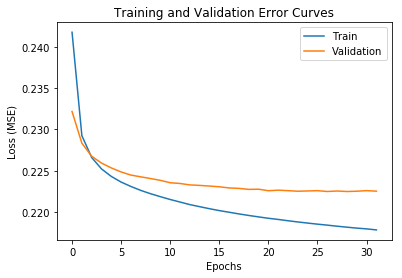

In [11]:
plot_training_error_curves(history)

Matriz de confusão no conjunto de teste:
[[22202 11323]
 [24504 39270]]

Train Loss:       0.2182
Validation Loss:  0.2225

Performance no conjunto de teste:


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


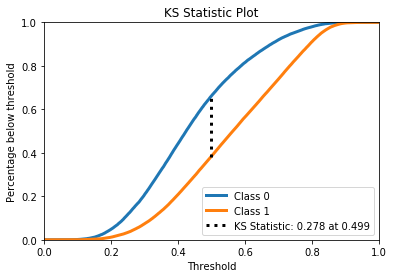


Accuracy:         0.6318
Recall:           0.6158
Precision:        0.7762
F1:               0.6867
AUROC:            0.6896
AUPR:             0.7998


In [12]:
# Fazer predições no conjunto de teste
y_pred_scores = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)
y_pred_scores_0 = 1 - y_pred_scores
y_pred_scores = np.concatenate([y_pred_scores_0, y_pred_scores], axis=1)

## Matriz de confusão
print('Matriz de confusão no conjunto de teste:')
print(confusion_matrix(y_test, y_pred_class))

## Resumo dos resultados
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print('\nPerformance no conjunto de teste:')
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, y_pred_class, y_pred_scores)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

# MLP 2
Quantidade de camadas intermediárias = 1
Quantidade de neurônios = 32, 16 e 1 respectivamente
Funções de ativação = relu, tanh e sigmoid respectivamente
Taxa de aprendizagem = 0.1

In [33]:
classifier = Sequential()

classifier.add(Dense(32, activation='relu'))
classifier.add(Dense(16, activation='tanh'))
classifier.add(Dense(1, activation='sigmoid'))

# Por fim compilamos o modelo especificando um otimizador, a função de custo, e opcionalmente
# métricas para serem observadas durante treinamento.
sgd = optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
classifier.compile(optimizer='sgd', loss='mean_squared_error')

# Para treinar a rede passamos o conjunto de treinamento e especificamos o tamanho do mini-batch,
# o número máximo de épocas, e opcionalmente callbacks. No seguinte exemplo utilizamos early
# stopping para interromper o treinamento caso a performance não melhore em um conjunto de validação.
history = classifier.fit(X_train, y_train, batch_size=64, epochs=100000, 
                         callbacks=[EarlyStopping(patience=3)], validation_data=(X_val, y_val))

Train on 255098 samples, validate on 127550 samples
Epoch 1/100000
255098/255098 [==============================] - 13s 51us/step - loss: 0.2409 - val_loss: 0.2334
Epoch 2/100000
255098/255098 [==============================] - 12s 45us/step - loss: 0.2306 - val_loss: 0.2301
Epoch 3/100000
255098/255098 [==============================] - 13s 49us/step - loss: 0.2277 - val_loss: 0.2284
Epoch 4/100000
255098/255098 [==============================] - 13s 50us/step - loss: 0.2260 - val_loss: 0.2272
Epoch 5/100000
255098/255098 [==============================] - 13s 50us/step - loss: 0.2248 - val_loss: 0.2266
Epoch 6/100000
255098/255098 [==============================] - 12s 46us/step - loss: 0.2239 - val_loss: 0.2260
Epoch 7/100000
255098/255098 [==============================] - 12s 48us/step - loss: 0.2231 - val_loss: 0.2256
Epoch 8/100000
255098/255098 [==============================] - 13s 51us/step - loss: 0.2225 - val_loss: 0.2253
Epoch 9/100000
255098/255098 [======================

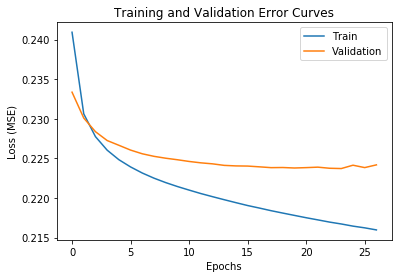

In [34]:
plot_training_error_curves(history)

Matriz de confusão no conjunto de teste:
[[21371 12154]
 [23425 40349]]

Train Loss:       0.2167
Validation Loss:  0.2237

Performance no conjunto de teste:


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


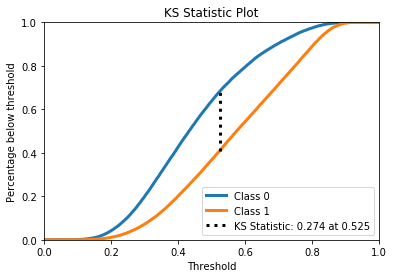


Accuracy:         0.6343
Recall:           0.6327
Precision:        0.7685
F1:               0.6940
AUROC:            0.6859
AUPR:             0.7979


In [35]:
y_pred_scores = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)
y_pred_scores_0 = 1 - y_pred_scores
y_pred_scores = np.concatenate([y_pred_scores_0, y_pred_scores], axis=1)

## Matriz de confusão
print('Matriz de confusão no conjunto de teste:')
print(confusion_matrix(y_test, y_pred_class))

## Resumo dos resultados
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print('\nPerformance no conjunto de teste:')
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, y_pred_class, y_pred_scores)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

# MLP 3
Quantidade de camadas intermediárias = 2
Quantidade de neurônios = 32, 64, 16 e 1 respectivamente
Funções de ativação = relu, tanh, softmax e sigmoid respectivamente
Taxa de aprendizagem = 0.1

In [36]:
classifier = Sequential()

classifier.add(Dense(32, activation='relu'))
classifier.add(Dense(64, activation='tanh'))
classifier.add(Dense(16, activation='softmax'))
classifier.add(Dense(1, activation='sigmoid'))

# Por fim compilamos o modelo especificando um otimizador, a função de custo, e opcionalmente
# métricas para serem observadas durante treinamento.
sgd = optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
classifier.compile(optimizer='sgd', loss='mean_squared_error')

# Para treinar a rede passamos o conjunto de treinamento e especificamos o tamanho do mini-batch,
# o número máximo de épocas, e opcionalmente callbacks. No seguinte exemplo utilizamos early
# stopping para interromper o treinamento caso a performance não melhore em um conjunto de validação.
history = classifier.fit(X_train, y_train, batch_size=64, epochs=100000, 
                         callbacks=[EarlyStopping(patience=3)], validation_data=(X_val, y_val))

Train on 255098 samples, validate on 127550 samples
Epoch 1/100000
255098/255098 [==============================] - 13s 53us/step - loss: 0.2496 - val_loss: 0.2487
Epoch 2/100000
255098/255098 [==============================] - 12s 48us/step - loss: 0.2478 - val_loss: 0.2466
Epoch 3/100000
255098/255098 [==============================] - 12s 49us/step - loss: 0.2448 - val_loss: 0.2429
Epoch 4/100000
255098/255098 [==============================] - 12s 46us/step - loss: 0.2402 - val_loss: 0.2379
Epoch 5/100000
255098/255098 [==============================] - 12s 47us/step - loss: 0.2352 - val_loss: 0.2337
Epoch 6/100000
255098/255098 [==============================] - 12s 49us/step - loss: 0.2315 - val_loss: 0.2309
Epoch 7/100000
255098/255098 [==============================] - 13s 49us/step - loss: 0.2291 - val_loss: 0.2293
Epoch 8/100000
255098/255098 [==============================] - 12s 47us/step - loss: 0.2277 - val_loss: 0.2283
Epoch 9/100000
255098/255098 [======================

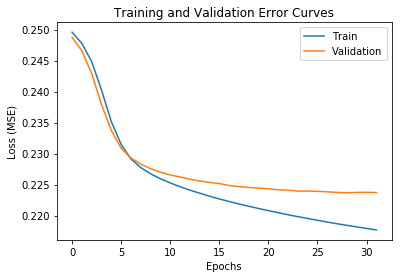

In [37]:
plot_training_error_curves(history)

Matriz de confusão no conjunto de teste:
[[22792 10733]
 [25824 37950]]

Train Loss:       0.2184
Validation Loss:  0.2237

Performance no conjunto de teste:


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


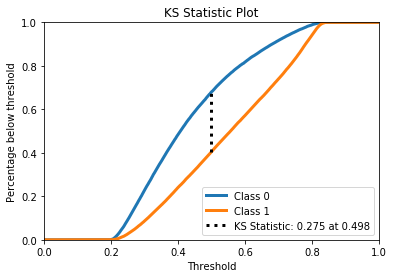


Accuracy:         0.6243
Recall:           0.5951
Precision:        0.7795
F1:               0.6749
AUROC:            0.6869
AUPR:             0.7986


In [38]:
y_pred_scores = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)
y_pred_scores_0 = 1 - y_pred_scores
y_pred_scores = np.concatenate([y_pred_scores_0, y_pred_scores], axis=1)

## Matriz de confusão
print('Matriz de confusão no conjunto de teste:')
print(confusion_matrix(y_test, y_pred_class))

## Resumo dos resultados
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print('\nPerformance no conjunto de teste:')
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, y_pred_class, y_pred_scores)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

# MLP 4
Quantidade de camadas intermediárias = 3
Quantidade de neurônios = 128, 32, 64, 16 e 1 respectivamente
Funções de ativação = relu, tanh, softmax, relu e sigmoid respectivamente
Taxa de aprendizagem = 0.01

In [39]:
classifier = Sequential()

classifier.add(Dense(128, activation='relu'))
classifier.add(Dense(32, activation='tanh'))
classifier.add(Dense(64, activation='softmax'))
classifier.add(Dense(16, activation='relu'))
classifier.add(Dense(1, activation='sigmoid'))

# Por fim compilamos o modelo especificando um otimizador, a função de custo, e opcionalmente
# métricas para serem observadas durante treinamento.
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
classifier.compile(optimizer='sgd', loss='mean_squared_error')

# Para treinar a rede passamos o conjunto de treinamento e especificamos o tamanho do mini-batch,
# o número máximo de épocas, e opcionalmente callbacks. No seguinte exemplo utilizamos early
# stopping para interromper o treinamento caso a performance não melhore em um conjunto de validação.
history = classifier.fit(X_train, y_train, batch_size=64, epochs=100000, 
                         callbacks=[EarlyStopping(patience=3)], validation_data=(X_val, y_val))

Train on 255098 samples, validate on 127550 samples
Epoch 1/100000
255098/255098 [==============================] - 19s 76us/step - loss: 0.2500 - val_loss: 0.2499
Epoch 2/100000
255098/255098 [==============================] - 18s 69us/step - loss: 0.2498 - val_loss: 0.2497
Epoch 3/100000
255098/255098 [==============================] - 19s 76us/step - loss: 0.2496 - val_loss: 0.2496
Epoch 4/100000
255098/255098 [==============================] - 16s 62us/step - loss: 0.2494 - val_loss: 0.2493
Epoch 5/100000
255098/255098 [==============================] - 18s 69us/step - loss: 0.2491 - val_loss: 0.2489
Epoch 6/100000
255098/255098 [==============================] - 19s 75us/step - loss: 0.2485 - val_loss: 0.2480
Epoch 7/100000
255098/255098 [==============================] - 18s 70us/step - loss: 0.2470 - val_loss: 0.2454
Epoch 8/100000
255098/255098 [==============================] - 18s 69us/step - loss: 0.2426 - val_loss: 0.2392
Epoch 9/100000
255098/255098 [======================

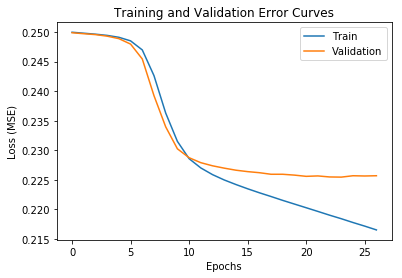

In [40]:
plot_training_error_curves(history)

Matriz de confusão no conjunto de teste:
[[21578 11947]
 [23881 39893]]

Train Loss:       0.2184
Validation Loss:  0.2254

Performance no conjunto de teste:


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


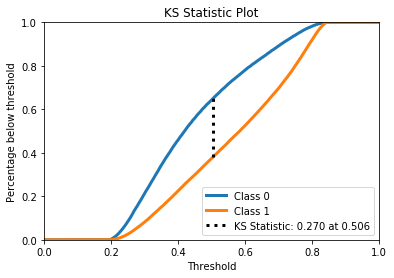


Accuracy:         0.6318
Recall:           0.6255
Precision:        0.7695
F1:               0.6901
AUROC:            0.6834
AUPR:             0.7955


In [41]:
y_pred_scores = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)
y_pred_scores_0 = 1 - y_pred_scores
y_pred_scores = np.concatenate([y_pred_scores_0, y_pred_scores], axis=1)

## Matriz de confusão
print('Matriz de confusão no conjunto de teste:')
print(confusion_matrix(y_test, y_pred_class))

## Resumo dos resultados
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print('\nPerformance no conjunto de teste:')
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, y_pred_class, y_pred_scores)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

# MLP 5
Quantidade de camadas intermediárias = 4
Quantidade de neurônios = 64, 32, 128, 32, 32 e 1 respectivamente
Funções de ativação = relu, tanh, softmax, relu, sigmoid, softmax respectivamente
Taxa de aprendizagem = 0.001

In [42]:
classifier = Sequential()

classifier.add(Dense(64, activation='relu'))
classifier.add(Dense(32, activation='tanh'))
classifier.add(Dense(128, activation='softmax'))
classifier.add(Dense(32, activation='relu'))
classifier.add(Dense(32, activation='sigmoid'))
classifier.add(Dense(1, activation='softmax'))

# Por fim compilamos o modelo especificando um otimizador, a função de custo, e opcionalmente
# métricas para serem observadas durante treinamento.
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
classifier.compile(optimizer='sgd', loss='mean_squared_error')

# Para treinar a rede passamos o conjunto de treinamento e especificamos o tamanho do mini-batch,
# o número máximo de épocas, e opcionalmente callbacks. No seguinte exemplo utilizamos early
# stopping para interromper o treinamento caso a performance não melhore em um conjunto de validação.
history = classifier.fit(X_train, y_train, batch_size=64, epochs=100000, 
                         callbacks=[EarlyStopping(patience=3)], validation_data=(X_val, y_val))

Train on 255098 samples, validate on 127550 samples
Epoch 1/100000
255098/255098 [==============================] - 17s 65us/step - loss: 0.5000 - val_loss: 0.5000
Epoch 2/100000
255098/255098 [==============================] - 16s 62us/step - loss: 0.5000 - val_loss: 0.5000
Epoch 3/100000
255098/255098 [==============================] - 16s 62us/step - loss: 0.5000 - val_loss: 0.5000
Epoch 4/100000
255098/255098 [==============================] - 16s 64us/step - loss: 0.5000 - val_loss: 0.5000


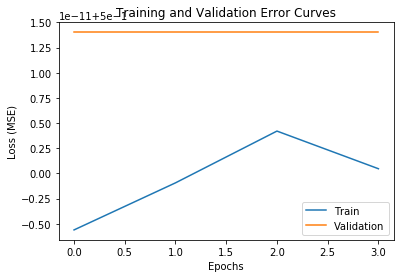

In [43]:
plot_training_error_curves(history)

Matriz de confusão no conjunto de teste:
[[    0 33525]
 [    0 63774]]

Train Loss:       0.5000
Validation Loss:  0.5000

Performance no conjunto de teste:


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


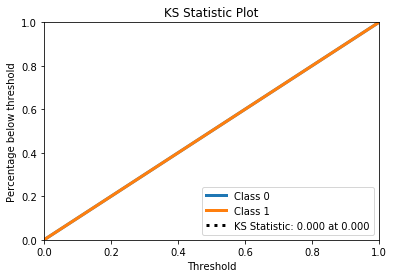


Accuracy:         0.6554
Recall:           1.0000
Precision:        0.6554
F1:               0.7919
AUROC:            0.5000
AUPR:             0.6554


In [44]:
y_pred_scores = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)
y_pred_scores_0 = 1 - y_pred_scores
y_pred_scores = np.concatenate([y_pred_scores_0, y_pred_scores], axis=1)

## Matriz de confusão
print('Matriz de confusão no conjunto de teste:')
print(confusion_matrix(y_test, y_pred_class))

## Resumo dos resultados
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print('\nPerformance no conjunto de teste:')
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, y_pred_class, y_pred_scores)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

# MLP 6
Quantidade de camadas intermediárias = 3
Quantidade de neurônios = 32, 64, 128, 64, 32 e 1 respectivamente
Funções de ativação = relu, tanh, softmax, relu, sigmoid, softmax respectivamente
Taxa de aprendizagem = 0.001

In [54]:
classifier = Sequential()

classifier.add(Dense(64, activation='tanh'))
classifier.add(Dense(32, activation='relu'))
classifier.add(Dense(32, activation='softmax'))
classifier.add(Dense(16, activation='softmax'))
classifier.add(Dense(1, activation='sigmoid'))

# Por fim compilamos o modelo especificando um otimizador, a função de custo, e opcionalmente
# métricas para serem observadas durante treinamento.
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
classifier.compile(optimizer='sgd', loss='mean_squared_error')

# Para treinar a rede passamos o conjunto de treinamento e especificamos o tamanho do mini-batch,
# o número máximo de épocas, e opcionalmente callbacks. No seguinte exemplo utilizamos early
# stopping para interromper o treinamento caso a performance não melhore em um conjunto de validação.
history = classifier.fit(X_train, y_train, batch_size=64, epochs=100000, 
                         callbacks=[EarlyStopping(patience=3)], validation_data=(X_val, y_val))

Train on 255098 samples, validate on 127550 samples
Epoch 1/100000
255098/255098 [==============================] - 14s 56us/step - loss: 0.2500 - val_loss: 0.2500
Epoch 2/100000
255098/255098 [==============================] - 14s 53us/step - loss: 0.2500 - val_loss: 0.2500
Epoch 3/100000
255098/255098 [==============================] - 14s 53us/step - loss: 0.2500 - val_loss: 0.2500
Epoch 4/100000
255098/255098 [==============================] - 14s 54us/step - loss: 0.2500 - val_loss: 0.2500
Epoch 5/100000
255098/255098 [==============================] - 14s 54us/step - loss: 0.2500 - val_loss: 0.2500
Epoch 6/100000
255098/255098 [==============================] - 13s 53us/step - loss: 0.2500 - val_loss: 0.2500
Epoch 7/100000
255098/255098 [==============================] - 13s 51us/step - loss: 0.2500 - val_loss: 0.2500
Epoch 8/100000
255098/255098 [==============================] - 14s 54us/step - loss: 0.2500 - val_loss: 0.2500
Epoch 9/100000
255098/255098 [======================

255098/255098 [==============================] - 14s 54us/step - loss: 0.2496 - val_loss: 0.2495
Epoch 74/100000
255098/255098 [==============================] - 14s 53us/step - loss: 0.2495 - val_loss: 0.2495
Epoch 75/100000
255098/255098 [==============================] - 14s 53us/step - loss: 0.2495 - val_loss: 0.2494
Epoch 76/100000
255098/255098 [==============================] - 14s 53us/step - loss: 0.2494 - val_loss: 0.2494
Epoch 77/100000
255098/255098 [==============================] - 13s 52us/step - loss: 0.2493 - val_loss: 0.2493
Epoch 78/100000
255098/255098 [==============================] - 13s 51us/step - loss: 0.2493 - val_loss: 0.2492
Epoch 79/100000
255098/255098 [==============================] - 14s 53us/step - loss: 0.2492 - val_loss: 0.2491
Epoch 80/100000
255098/255098 [==============================] - 14s 54us/step - loss: 0.2490 - val_loss: 0.2489
Epoch 81/100000
255098/255098 [==============================] - 14s 54us/step - loss: 0.2489 - val_loss: 0.2488

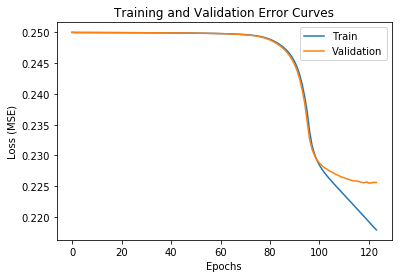

In [55]:
plot_training_error_curves(history)

Matriz de confusão no conjunto de teste:
[[22520 11005]
 [25696 38078]]

Train Loss:       0.2192
Validation Loss:  0.2255

Performance no conjunto de teste:


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


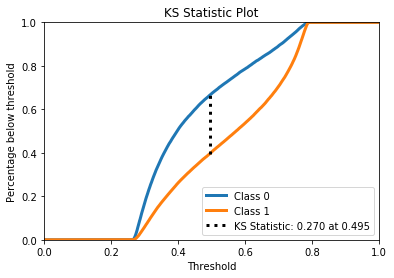


Accuracy:         0.6228
Recall:           0.5971
Precision:        0.7758
F1:               0.6748
AUROC:            0.6813
AUPR:             0.7917


In [56]:
y_pred_scores = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)
y_pred_scores_0 = 1 - y_pred_scores
y_pred_scores = np.concatenate([y_pred_scores_0, y_pred_scores], axis=1)

## Matriz de confusão
print('Matriz de confusão no conjunto de teste:')
print(confusion_matrix(y_test, y_pred_class))

## Resumo dos resultados
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print('\nPerformance no conjunto de teste:')
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, y_pred_class, y_pred_scores)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)